## Solutions Proposed to Olist

A late delivery occurs when an order's actual shipping date exceeds its estimated delivery date. This creates a gap between customer expectations and our operational capabilities. So we propose two solutions:

1. *Develop more realistic delivery timeframes based on historical data, ensuring we can consistently meet or exceed customer expectations*

2. *If the goal is to deliver fast, can we estimate the capacity of orders we're able to timely deliver? This could have an impact on number of orders*


**This analysis will explore both solutions, providing actionable metrics and recommendations for implementation**


In [675]:
import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore
plt.style.use('ggplot')

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [729]:
# functions
def assign_time_of_day(hour):
    if 5 <= hour < 12:  # Morning: 5 AM to 11:59 AM
        return 0
    elif 12 <= hour < 17:  # Afternoon: 12 PM to 4:59 PM
        return 1
    elif 17 <= hour < 21:  # Evening: 5 PM to 8:59 PM
        return 2
    else:  # Night: 9 PM to 4:59 AM
        return 3
    
# plotting 
def plot_data(df, col_plot_1, col_plot_2, label_plot_1, label_plot_2, title):
    fig, ax1 = plt.subplots(figsize=(20, 8))

    ax1.plot(df[col_plot_1], color='blue')
    ax1.set_ylabel(label_plot_1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df[col_plot_2], color='orange', alpha=0.5)
    ax2.set_ylabel(label_plot_2, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    fig.suptitle(title, fontsize=16)
    ax1.set_xlabel('Date')
    plt.show()

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_pred, y_true))

In [740]:
df = pd.read_csv("../data/processed/data2.csv", parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [741]:
df['purchase_date_hour'] = df['order_purchase_timestamp'].dt.floor('H')
df['gap_in_minutes_approved_and_ordered'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_timestamp'].dt.date)


temp_df = df[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date', 
              'late_delivery_in_days', 'is_delivery_late', 'month', 'purchase_date_hour', 'gap_in_minutes_approved_and_ordered',
              'order_purchase_date']]
temp_df.head(1)

,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,late_delivery_in_days,is_delivery_late,month,purchase_date_hour,gap_in_minutes_approved_and_ordered,order_purchase_date
0,2017-09-26 22:17:05,2017-09-27 22:24:16,2017-10-07 16:12:47,2017-10-30,-23,0,9,2017-09-26 22:00:00,24.119722,2017-09-26


### Percentage of late deliveries by week

In [670]:
weekly_data = temp_df.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum'))

In [671]:
weekly_data.sort_values(by='num_late_deliveries').corr()

,count_orders,num_late_deliveries
count_orders,1.00000,0.69895
num_late_deliveries,0.69895,1.00000


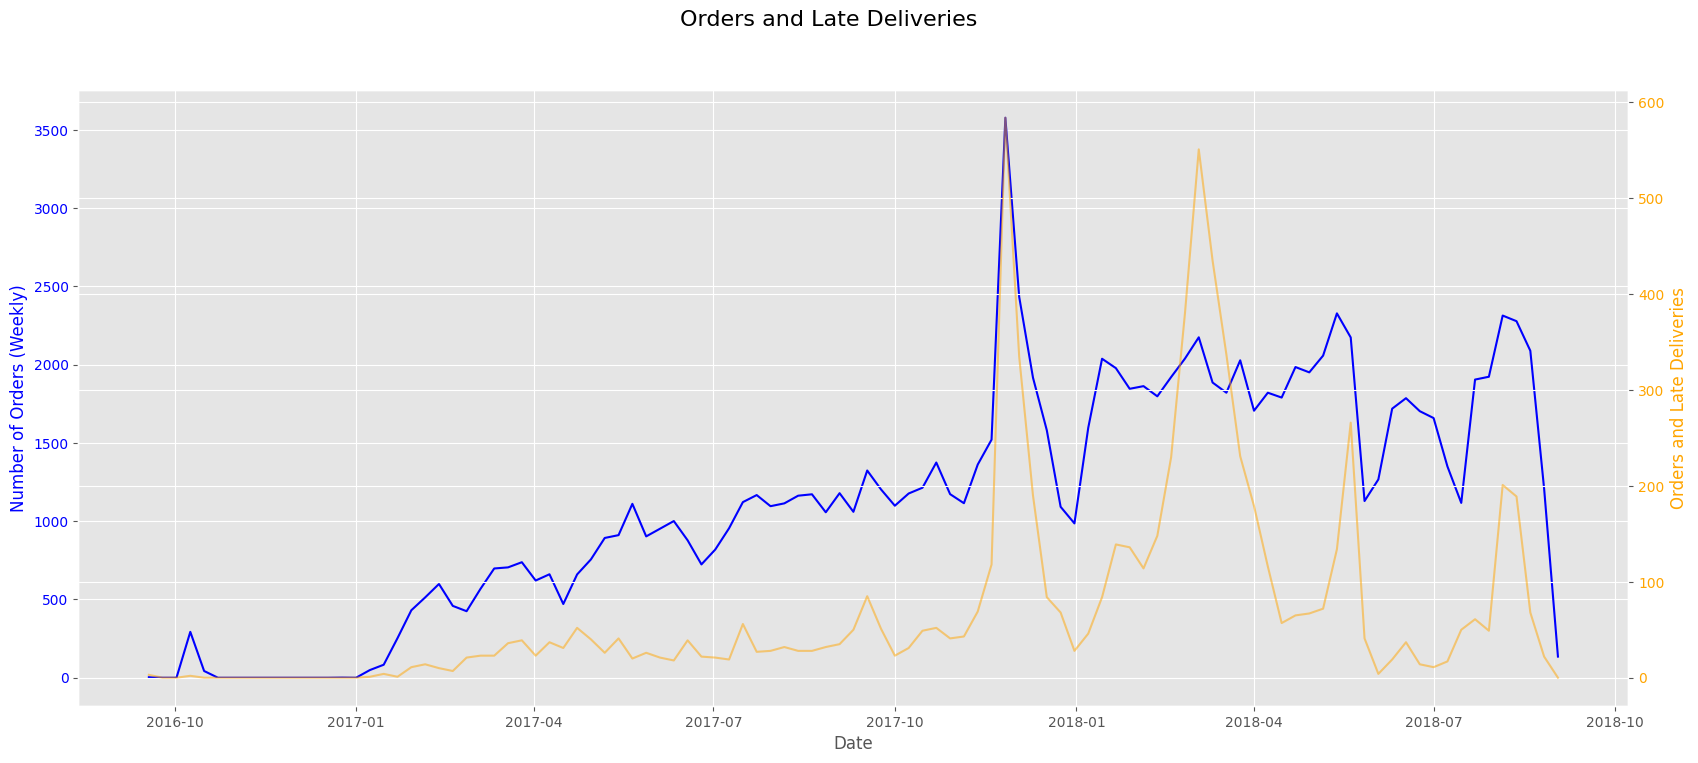

In [672]:
plot_data(df=weekly_data,
          col_plot_1='count_orders', 
          col_plot_2='num_late_deliveries', 
          label_plot_1='Number of Orders (Weekly)', 
          label_plot_2='Orders and Late Deliveries', 
          title='Orders and Late Deliveries')

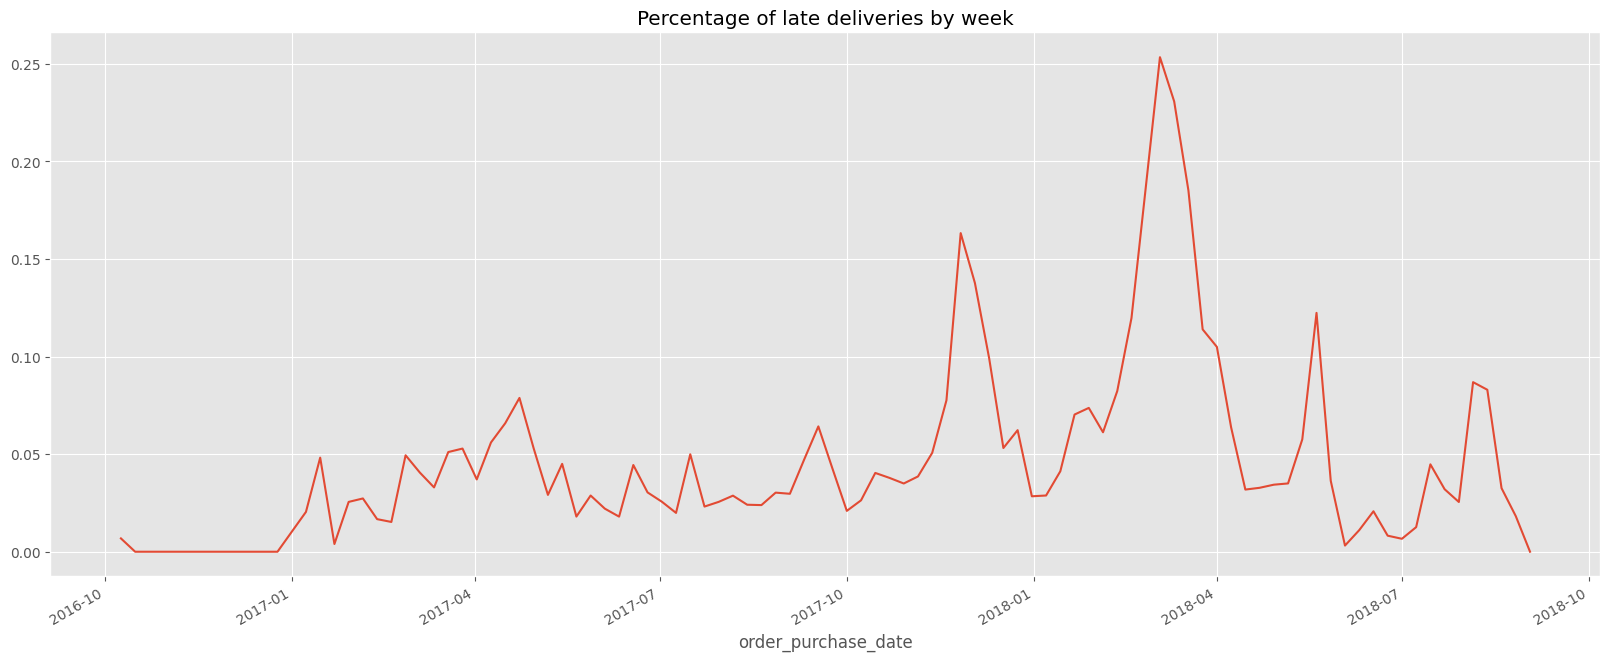

In [673]:
weekly_data['perc_late_deliveries'] = weekly_data['num_late_deliveries'] / weekly_data['count_orders']
plt.figure(figsize=(20, 8))
weekly_data[(weekly_data['perc_late_deliveries'].notna()) & (weekly_data['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot()
plt.title("Percentage of late deliveries by week")
plt.show()

---

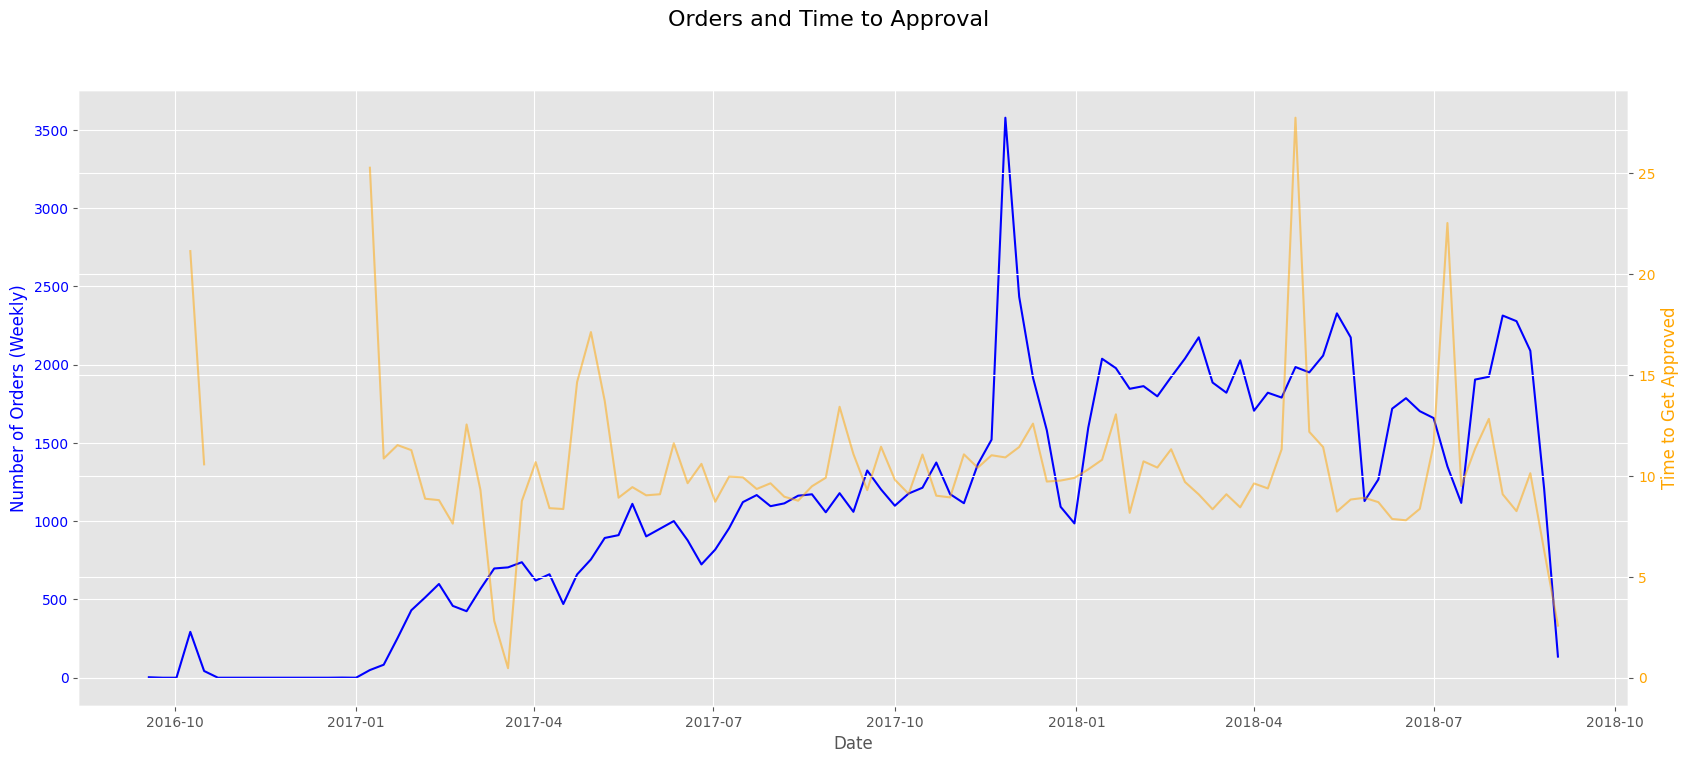

In [674]:
# Group by weekly periods and aggregate data
weekly_data = temp_df.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('purchase_date_hour', 'count'),
    gap_approved_ordered = ('gap_in_minutes_approved_and_ordered', 'mean')
)

plot_data(df=weekly_data,
          col_plot_1='count_orders', 
          col_plot_2='gap_approved_ordered', 
          label_plot_1='Number of Orders (Weekly)', 
          label_plot_2='Time to Get Approved', 
          title='Orders and Time to Approval')

---

## Expectation Management

1. *Develop more realistic delivery timeframes based on historical data, ensuring we can consistently meet or exceed customer expectations*

In the dataset provided by Olist, we're given the *ordered_delivered_customer_date* and the *order_estimated_delivery_date*, so we're given the actual and the predicted values which allows to estimate the RMSE, that we could use as benchmark to try and create a model that's better than the one they currently have.



In [769]:
df['dow'] = df['order_purchase_timestamp'].dt.day_of_week
df['hour'] = df['order_purchase_timestamp'].dt.hour
df['time_of_day'] = df['order_purchase_timestamp'].dt.hour.map(assign_time_of_day)

df['days_to_actual_delivery'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['days_to_actual_delivery_log'] = np.log(df['days_to_actual_delivery']+1)
df['days_to_estimated_delivery'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

df['is_december'] = 0
df.loc[df['month'].isin([11,12]), 'is_december'] = 1

df['is_summer'] = 0
df.loc[df['month'].isin([5,6,7,8]), 'is_summer'] = 1

- Root Mean Squared Error: 15 days. On average, estimated deliveries are off from actual deliveries by 15 days


In [770]:
np.sqrt(mean_squared_error(df['days_to_estimated_delivery'], df['days_to_actual_delivery']))

- In this case, only one direction matters. Customers would not care, and would actually prefer if deliveries are early, meaning: 
    
**actual delivery < estimated delivery**

- The issue arises when the actual delivery comes after the estimated delivery, meaning:

**actual delivery > estimated delivery**

In [771]:
df_late_orders = df[df['is_delivery_late'] == 1]
np.sqrt(mean_squared_error(df_late_orders['days_to_estimated_delivery'], df_late_orders['days_to_actual_delivery']))

On average, when deliveries are late, they're late by 18 days.

**Problem:** The current model predicts late deliveries with an RMSE of 18 days, setting our benchmark.

**Solution:** Build a predictive model that outperforms this benchmark using the available features.

In [772]:
df_clean = df.drop_duplicates(subset=['order_id'])
df_clean.sort_values(by='order_purchase_timestamp', inplace=True)

In [773]:
df_clean['purchase_date_hour'] = df_clean['order_purchase_timestamp'].dt.floor('H')
df_clean['week_start'] = (df['order_purchase_timestamp'] - pd.to_timedelta(df['order_purchase_timestamp'].dt.weekday + 1, unit='D')).dt.date
df_clean['week_start'] = pd.to_datetime(df_clean['week_start'])

In [774]:
weekly_data = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum')).reset_index()

weekly_data['perc_late_deliveries'] = weekly_data['num_late_deliveries'] / weekly_data['count_orders']
weekly_data['perc_late_deliveries'].fillna(0, inplace=True)
weekly_data.head(2)

,order_purchase_date,count_orders,num_late_deliveries,perc_late_deliveries
0,2016-09-18,1,1,1.0
1,2016-09-25,0,0,0.0


In [775]:
df_clean = pd.merge(df_clean, weekly_data, how='left', left_on='week_start', right_on='order_purchase_date', suffixes=('', '_duplicate'))

for i in range(1,3):
    df_clean[f'perc_late_deliveries_lag_{i}'] = df_clean['perc_late_deliveries'].shift(i)
    df_clean.dropna(subset=[f'perc_late_deliveries_lag_{i}'], inplace=True)

In [776]:
df_clean[['days_to_actual_delivery', 'perc_late_deliveries', 'perc_late_deliveries_lag_1', 'perc_late_deliveries_lag_2']].corr()

,days_to_actual_delivery,perc_late_deliveries,perc_late_deliveries_lag_1,perc_late_deliveries_lag_2
days_to_actual_delivery,1.000000,0.188378,0.188358,0.188346
perc_late_deliveries,0.188378,1.000000,0.999881,0.999763
perc_late_deliveries_lag_1,0.188358,0.999881,1.000000,0.999881
perc_late_deliveries_lag_2,0.188346,0.999763,0.999881,1.000000


## Features

In [816]:
features = [
'is_summer',
'freight_value',
'distance_km',
'month',
'dow',
'is_december',
'is_delivery_late',
'perc_late_deliveries_lag_1']

target = 'days_to_actual_delivery_log'

df_clean['days_to_actual_delivery'] = (df_clean['order_delivered_customer_date'] - df_clean['order_purchase_timestamp']).dt.days
df_clean.dropna(subset=['days_to_actual_delivery'], inplace=True)
df_clean['days_to_actual_delivery_log'] = np.log(df_clean['days_to_actual_delivery']+1)

## Multiple Linear Regression

In [817]:
X, y = df_clean[features], df_clean[target]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     days_to_actual_delivery_log   R-squared:                       0.441
Model:                                     OLS   Adj. R-squared:                  0.441
Method:                          Least Squares   F-statistic:                     9444.
Date:                         Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                                 17:04:09   Log-Likelihood:                -64840.
No. Observations:                        95810   AIC:                         1.297e+05
Df Residuals:                            95801   BIC:                         1.298e+05
Df Model:                                    8                                         
Covariance Type:                     nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [818]:
y_pred_linear_reg = model.predict(X)

## Ensemble Model

In [889]:
rf_model = RandomForestRegressor().fit(X,y)
y_pred_random_forest = rf_model.predict(X)

# Get individual tree predictions
tree_predictions = np.array([tree.predict(X) for tree in rf_model.estimators_])

# Calculate the 75th percentile for each sample
percentile_90_predictions = np.percentile(tree_predictions, 95, axis=0)

# Evaluation

In [890]:
temp_df = df_clean[['is_delivery_late', 'days_to_actual_delivery', 'days_to_estimated_delivery']]
extra_error = 10
temp_df['lin_reg_predictions'] = np.exp(y_pred_linear_reg) - 1 
temp_df['random_forest_predictions'] = np.exp(percentile_90_predictions) - 1 
df_late_delivery = temp_df[temp_df['is_delivery_late'] == 1]
df_late_delivery.head(2)

,is_delivery_late,days_to_actual_delivery,days_to_estimated_delivery,lin_reg_predictions,random_forest_predictions
43,1,55,54,21.290481,70.0
53,1,68,50,20.428212,68.0


In [891]:
rsme_dict = {
            'olist_current_model': root_mean_squared_error(df_late_delivery['days_to_actual_delivery'], df_late_delivery['days_to_estimated_delivery']),
            'linear_reg_model': root_mean_squared_error(df_late_delivery['days_to_actual_delivery'], df_late_delivery['lin_reg_predictions']),
            'random_forest_model': root_mean_squared_error(df_late_delivery['days_to_actual_delivery'], df_late_delivery['random_forest_predictions'])
        }

pd.DataFrame(rsme_dict, index=[0])

,olist_current_model,linear_reg_model,random_forest_model
0,18.235221,20.618135,22.054141


In [892]:
root_mean_squared_error(temp_df['days_to_actual_delivery'], temp_df['days_to_estimated_delivery'])

In [893]:
extra_error = 5
df_clean['days_to_estimated_delivery_lin_reg'] = np.exp(y_pred_linear_reg) - 1 
df_clean['days_to_estimated_delivery_random_forest'] = np.exp(percentile_90_predictions) - 1 


df_clean['is_delivery_late_lin_reg'] = np.where(df_clean['days_to_actual_delivery'] > df_clean['days_to_estimated_delivery_lin_reg'], 1, 0)
df_clean['is_delivery_late_random_forest'] = np.where(df_clean['days_to_actual_delivery'] > df_clean['days_to_estimated_delivery_random_forest'], 1, 0)

In [894]:
df_clean['is_delivery_late_random_forest'].value_counts()

is_delivery_late_random_forest
0    88997
1     6813
Name: count, dtype: int64

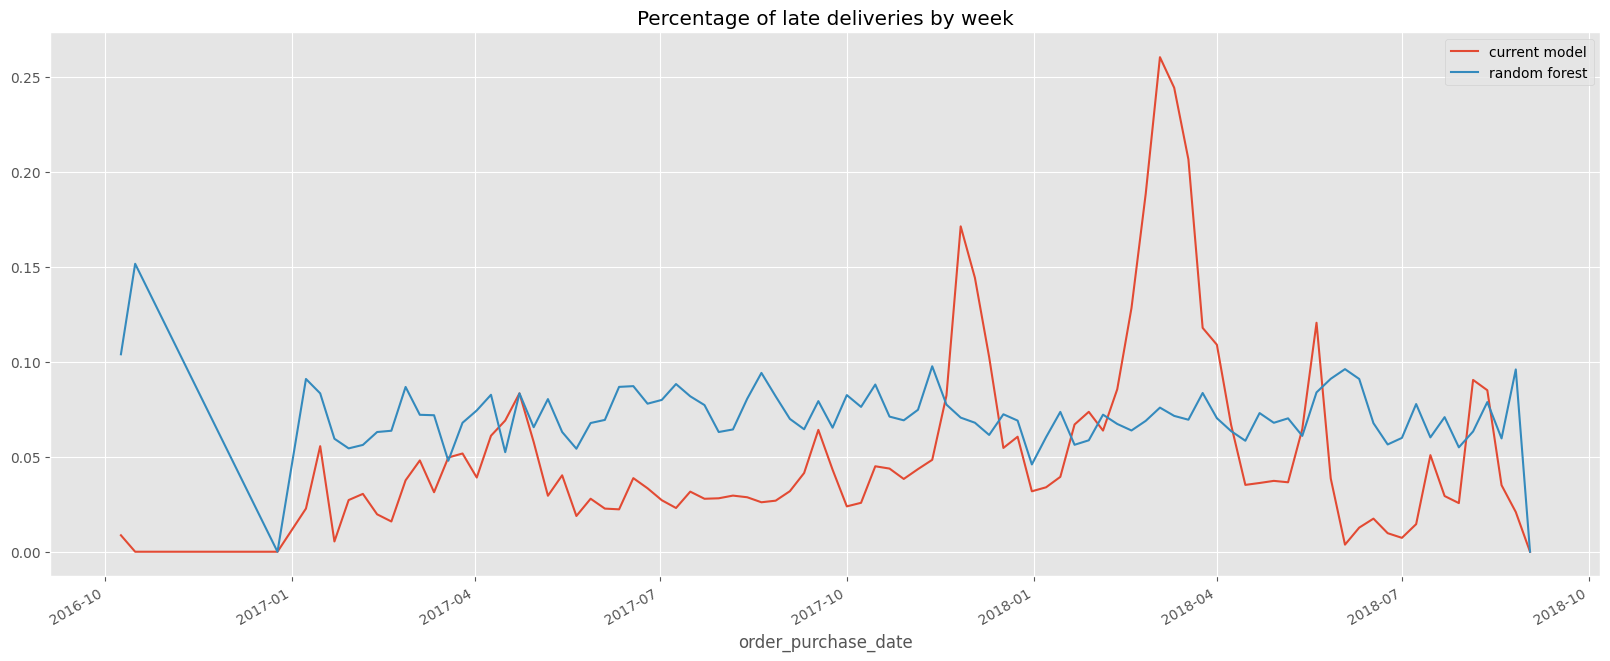

In [897]:
weekly_data_model_1 = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum'))


weekly_data_model_2 = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late_lin_reg', 'sum'))

weekly_data_model_3 = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late_random_forest', 'sum'))


weekly_data['perc_late_deliveries'] = weekly_data['num_late_deliveries'] / weekly_data['count_orders']
weekly_data_model_2['perc_late_deliveries'] = weekly_data_model_2['num_late_deliveries'] / weekly_data_model_2['count_orders']
weekly_data_model_3['perc_late_deliveries'] = weekly_data_model_3['num_late_deliveries'] / weekly_data_model_3['count_orders']

plt.figure(figsize=(20, 8))
weekly_data[(weekly_data['perc_late_deliveries'].notna()) & (weekly_data['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label='current model')
#weekly_data_model_2[(weekly_data_model_2['perc_late_deliveries'].notna()) & (weekly_data_model_2['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label='linear regression')
weekly_data_model_3[(weekly_data_model_3['perc_late_deliveries'].notna()) & (weekly_data_model_3['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label='random forest')
plt.title("Percentage of late deliveries by week")
plt.legend()
plt.show()

---

**Resources**

instacart technical blog: great resource: https://tech.instacart.com/building-a-data-science-product-in-10-days-d2f4688567b0